In [5]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = True

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, MultipleLocator
from matplotlib import patheffects as pe
import numpy as np
from copy import deepcopy
from cmcrameri import cm

import scipy.integrate as integ

In [6]:
# %matplotlib widget

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
# constants
sbc = 5.67e-8   # stefan-boltzman constant
M_E = 6e24 # Rarth mass [kg]
day = 24.0*60*60 # length of day in seconds
year = 365.24 * day
S_earth = 1361.0

In [8]:
class planet():

    def __init__(self):

        # parameters
        self.c_p = 1250.0     # heat capacity [J kg-1 K-1]
        self.rho = 4550.0    # density [kg m-3]
        self.S_0 = 24.7 * S_earth   # instellation at t=0 [W m-2]
        self.dSx = 0.0       # rate of change of instellation dS/dt [W m-2 s-1]
        self.T_0 = 3500.0    # initial temperature [K]
        self.T_s = 1500.0    # solidus temperature [K]
        self.T_l = 2000.0    # liquidus temperature [K]
        self.alb = 0.3       # shortwave albedo
        self.ems = 0.7       # longwave emissivity
        self.M_p = 0.47 * M_E   # mass of planet [kg]
        self.F_c = 0.0       # internal heat flux [W m-2]

        # Derived quantities
        self.r2   = (3 * self.M_p / (4 * self.rho * np.pi))**(2.0/3.0) # radius squared
        self.T_cen = 0.5*(self.T_s + self.T_l)
        self.T_wid = 0.5*(self.T_l - self.T_s)

        # result
        self.sol_tim = None # time
        self.sol_tmp = None # temperature
        self.sol_ins = None # instellation

    # Calculate melt fraction from temperature
    def _phi(self, tmp):
        if tmp <= self.T_s:
            # fully solid
            return 0.0
        elif tmp >= self.T_l:
            # fully liquid
            return 1.0
        else:
            # mushy
            return (tmp - self.T_s)/(self.T_l-self.T_s)

    # Rate of change in temperature
    def _dTdx(self, Tt, S0):
        # interior heating
        F_int = self.F_c * np.exp(-1.0 * ((Tt-self.T_cen)/self.T_wid)**2)
        out  = 0.0
        out += (1-self.alb)*S0/4.0
        out += F_int
        out -= sbc * self.ems * Tt**4
        out *= 4 * np.pi * self.r2 / (self.M_p * self.c_p)
        return out

    def _dSdx(self, S0):
        if S0 <= 0:
            return 0.0
        else:
            return self.dSx

    # ODE to solve
    def _ode(self, t, y):
        return (self._dTdx(y[0],y[1]),self._dSdx(y[1]))

    # Evolve system over time
    def solve(self, t_max, nsamps=1000, linspace=False, rtol=1e-3, atol=1e-6):

        t_span = (0,t_max*year*1.01)
        if linspace:
            t_eval = np.append([0.1],np.linspace(day, t_max*year, int(nsamps)))
        else:
            t_eval = np.append([0.1],np.logspace(np.log10(day), np.log10(t_max*year), int(nsamps)))

        result = integ.solve_ivp(self._ode, t_span, (self.T_0,self.S_0),
                                    first_step=day/10, t_eval=t_eval, rtol=rtol, atol=atol)

        self.sol_tim = result.t / year
        self.sol_tmp = result.y[0]
        self.sol_ins = result.y[1]
        succ = result.success
        if not succ:
            print("Success:",succ)
            print("\t",result.message)

        return self.sol_tim, self.sol_tmp, self.sol_ins



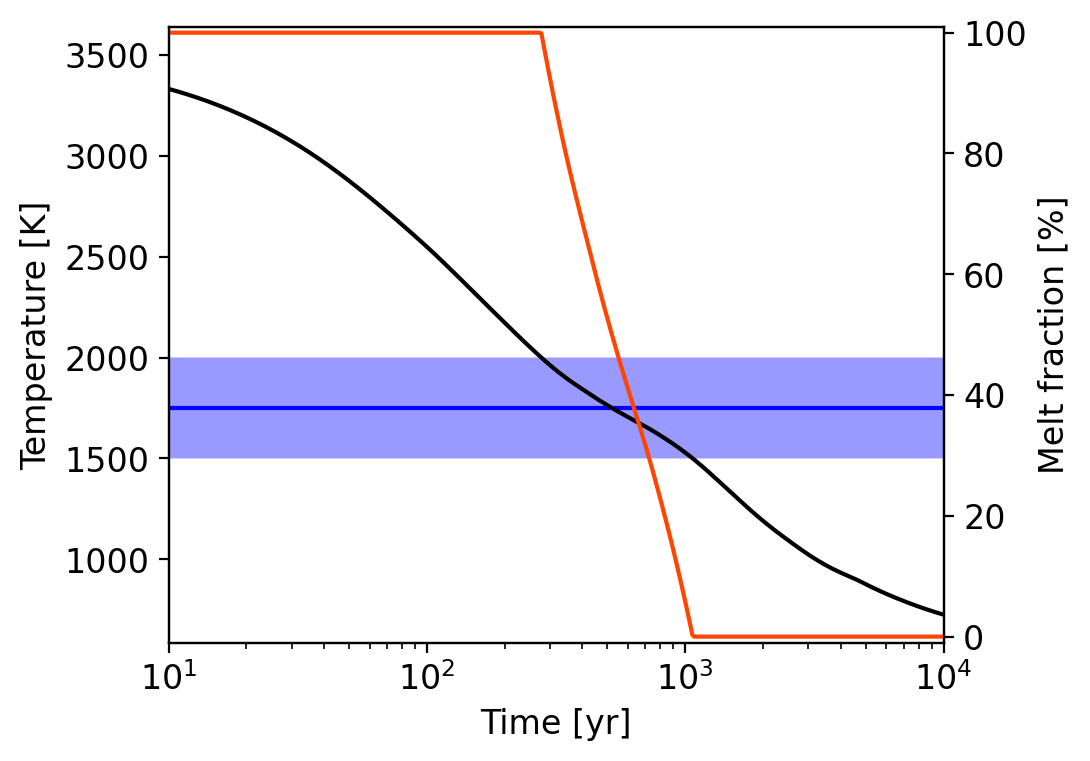

In [9]:
# single case

pl = planet()
pl.F_c = 5 * pl.S_0
sol_tim, sol_tmp, sol_ins = pl.solve(1e4)
sol_phi = [pl._phi(y)*100 for y in sol_tmp]

fig, ax = plt.subplots(1,1, figsize=(5,4))
axr = ax.twinx()

ax.fill_between(sol_tim, pl.T_cen+pl.T_wid, pl.T_cen-pl.T_wid, color='b', alpha=0.4, edgecolor=None)
ax.axhline(pl.T_cen, color='b')

ax.plot(sol_tim, sol_tmp, color='k')

ax.set_xlabel("Time [yr]")
ax.set_ylabel("Temperature [K]")
ax.set_xscale("log")
ax.set_xlim(10, sol_tim[-1])

axr.plot(sol_tim, sol_phi, color='orangered')
axr.set_ylabel("Melt fraction [%]")
axr.set_ylim(bottom=-1, top=101)

plt.show()


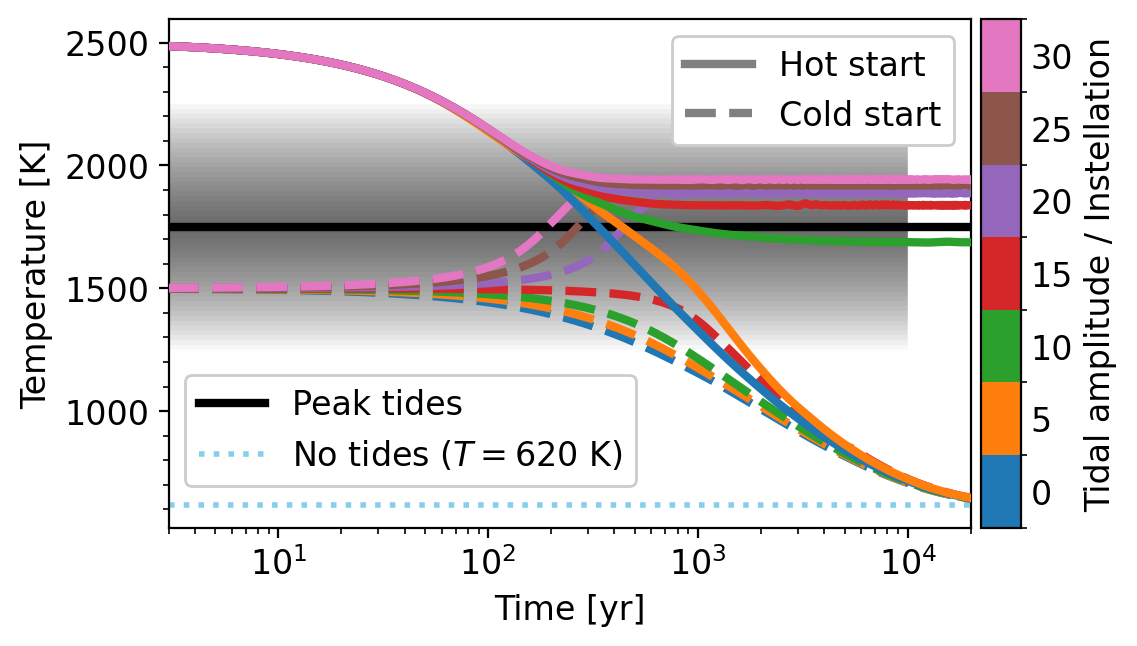

In [10]:
# multiple cases
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))

# mixed phase region
res = 25
for q in np.linspace(0.1, 2.0, res):
    ax.fill_between(sol_tim, pl.T_cen+pl.T_wid*q, pl.T_cen-pl.T_wid*q, color='k', alpha=0.8/res, edgecolor=None, zorder=0)
ax.axhline(pl.T_cen, color='k', label="Peak tides", ls='solid', lw=3, zorder=1)


# null hypothesis
pl = planet()
sol_tim, sol_tmp, sol_ins = pl.solve(t_max=1e7)
y_noh = float(sol_tmp[-1])
ax.axhline(y=y_noh, color='skyblue', linestyle='dotted', label=r"No tides ($T=%.0f$ K)"%y_noh, lw=2)

dx = 5
x_arr = np.arange(0, 30.0+dx, dx)
lw = 3
cmap = "tab10"
norm = mpl.colors.BoundaryNorm(boundaries=np.append(x_arr, x_arr[-1]+dx)-dx/2, ncolors=len(x_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 1500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_tim, sol_tmp, sol_ins = pl.solve(t_max=2e4)
    ax.plot(sol_tim, sol_tmp, color=sm.to_rgba(x), ls='dashed', zorder=3, lw=lw)#, path_effects=[pe.Stroke(linewidth=lw*1.8, foreground='w'), pe.Normal()])

for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_tim, sol_tmp, sol_ins = pl.solve(t_max=2e4)
    ax.plot(sol_tim, sol_tmp, color=sm.to_rgba(x), zorder=4, lw=lw)#, path_effects=[pe.Stroke(linewidth=lw*1.8, foreground='w'), pe.Normal()])

mappable = sm # mappable for colorbar
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mappable, cax=cax, orientation='vertical', ticks=x_arr)
cbar.ax.tick_params(size=0)
cbar.set_label("Tidal amplitude / Instellation")

ax.set_xlabel("Time [yr]")
ax.set_xscale("log")
ax.set_xlim(left=3, right=sol_tim[-1])
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.set_ylabel("Temperature [K]")
leg1 = ax.legend(framealpha=1.0, loc='lower left', bbox_to_anchor=(0,0.05))


hdl1 = ax.plot([0,1],[1000,1500], lw=lw, color='grey', label="Hot start")[0]
hdl2 = ax.plot([0,1],[1000,1500], lw=lw, color='grey', label="Cold start", ls='dashed')[0]
leg2 = ax.legend(framealpha=1.0, loc='upper right', handles=(hdl1, hdl2,))
ax.add_artist(leg1)

plt.show()
fig.savefig("output/sa_evolve.pdf", bbox_inches="tight")

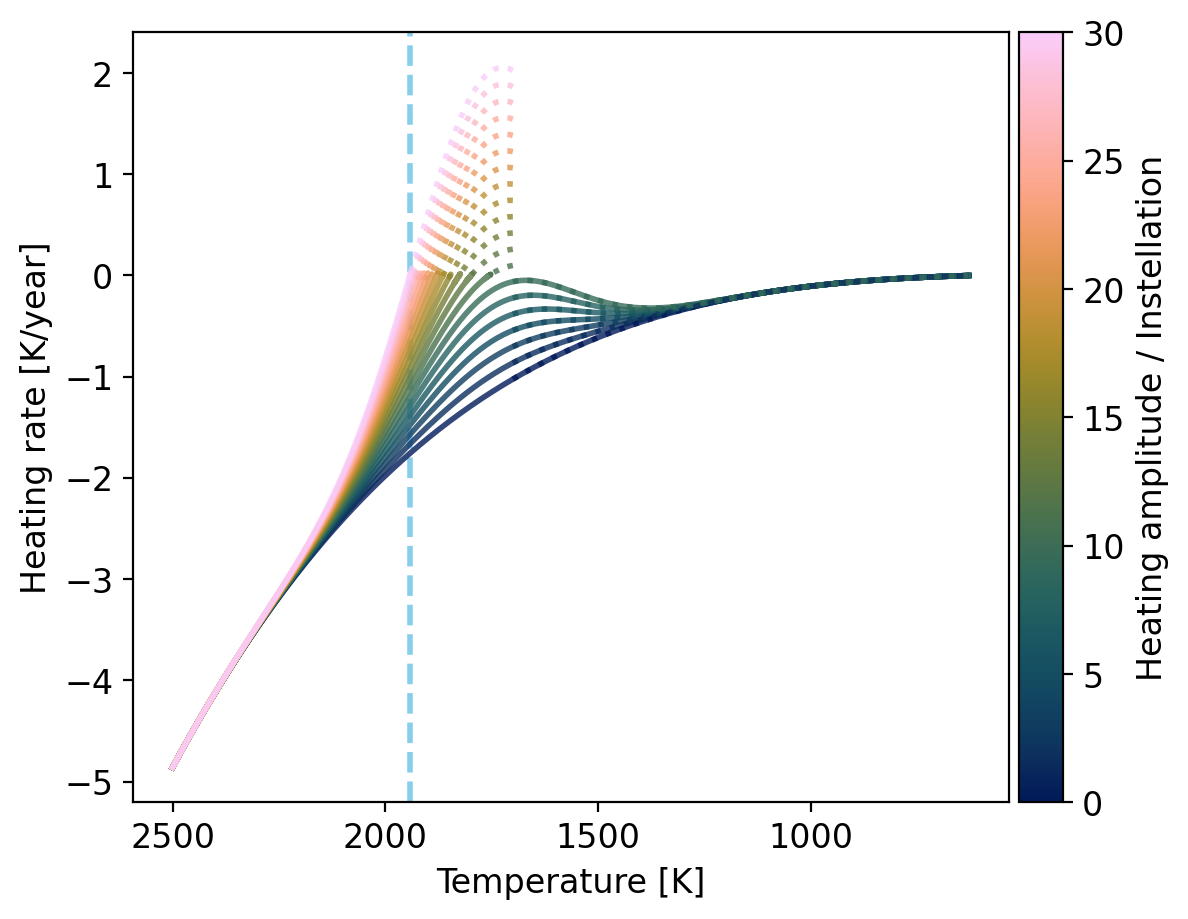

In [11]:
# multiple cases
fig, ax = plt.subplots(1,1, figsize=(6,5))

x_arr = np.linspace(0, 30.0, 20)

y_noh = float(sol_tmp[-1])
ax.axvline(x=y_noh, color='skyblue', linestyle='dashed', label=r"No tides ($T=%d$ K)"%y_noh, lw=2)


lw = 2
cmap = cm.batlow
norm = mpl.colors.Normalize(vmin=x_arr[0], vmax=x_arr[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_tim, sol_tmp, sol_ins = pl.solve(t_max=3e4)
    plt_x = sol_tmp[1:]
    plt_y = [pl._dTdx(Tt,pl.S_0)*year for Tt in plt_x]
    ax.plot(plt_x, plt_y, color=sm.to_rgba(x), ls='solid', lw=lw, alpha=0.8)

for x in x_arr:
    pl = planet()
    pl.T_0 = 1700
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_tim, sol_tmp, sol_ins = pl.solve(t_max=3e4)
    plt_x = sol_tmp[1:]
    plt_y = [pl._dTdx(Tt,pl.S_0)*year for Tt in plt_x]
    ax.plot(plt_x, plt_y, color=sm.to_rgba(x), ls='dotted', lw=lw, alpha=0.8)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label("Heating amplitude / Instellation")

ax.set_xlabel("Temperature [K]")
ax.invert_xaxis()
ax.set_ylabel("Heating rate [K/year]")

plt.show()

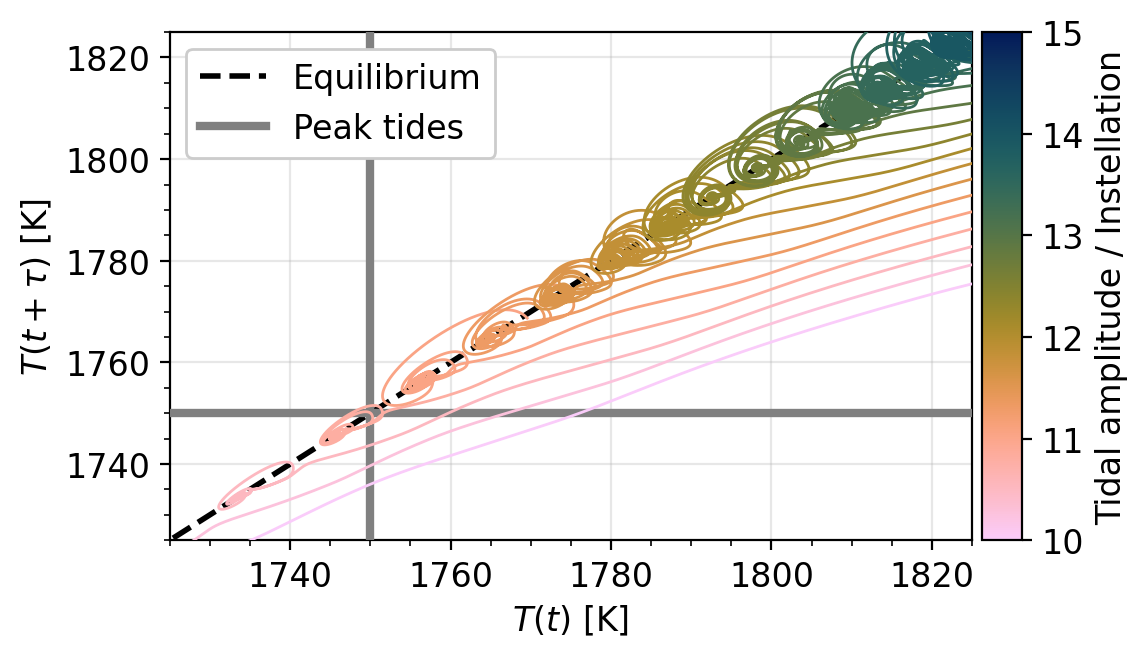

In [12]:
# multiple cases
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))

x_arr = np.linspace(10, 15.0, 20)

di = 100

cmap = cm.batlow_r
norm = mpl.colors.Normalize(vmin=x_arr[0], vmax=x_arr[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_tim, sol_tmp, sol_ins = pl.solve(t_max=2e4, nsamps=di*100, linspace=True)
    dt = float(sol_tim[30]-sol_tim[29])
    plt_c = plt_x

    plt_x = sol_tmp[1:-1*di]
    plt_y = sol_tmp[1+di:]

    # ax.scatter(plt_x, plt_y, c=plt_x, s=2, zorder=5, cmap=cmap, norm=norm)
    ax.plot(plt_x, plt_y, lw=1, zorder=5, color=sm.to_rgba(x))

ax.plot([0,pl.T_0],[0,pl.T_0], zorder=2, color='k', lw=2, label="Equilibrium", ls='dashed')
ax.axhline(pl.T_cen, color='grey', label="Peak tides", lw=3, zorder=3)
ax.axvline(pl.T_cen, color='grey', lw=3, zorder=3)

# ax.plot(-1, -1, lw=1, zorder=5, color='grey', label=r"$\tau = $%.g years"%dt)

ax.set_xlim(1725, 1825)
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.set_ylim(1725, 1825)
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label("Tidal amplitude / Instellation")

ax.set_xlabel(r"$T(t)$ [K]")
ax.set_ylabel(r"$T(t+\tau)$ [K]")
ax.grid(zorder=-3, alpha=0.3)
ax.legend(framealpha=1.0, loc='upper left')

plt.show()
fig.savefig("output/sa_logistic.pdf", bbox_inches="tight")

In [13]:
x_arr = []
y_arr = []
z_arr = []

for x in np.linspace(1350, 1800, 40): # initial temperature
    for y in np.linspace(0, 30,  40): # heating maximum
        pl = planet()
        pl.T_0 = x
        pl.F_c = y * pl.S_0

        # solve
        sol_x, sol_y, _ = pl.solve(t_max=1e4, rtol=1e-6)

        # store
        x_arr.append(x)
        y_arr.append(y)
        z_arr.append(sol_y[-1])

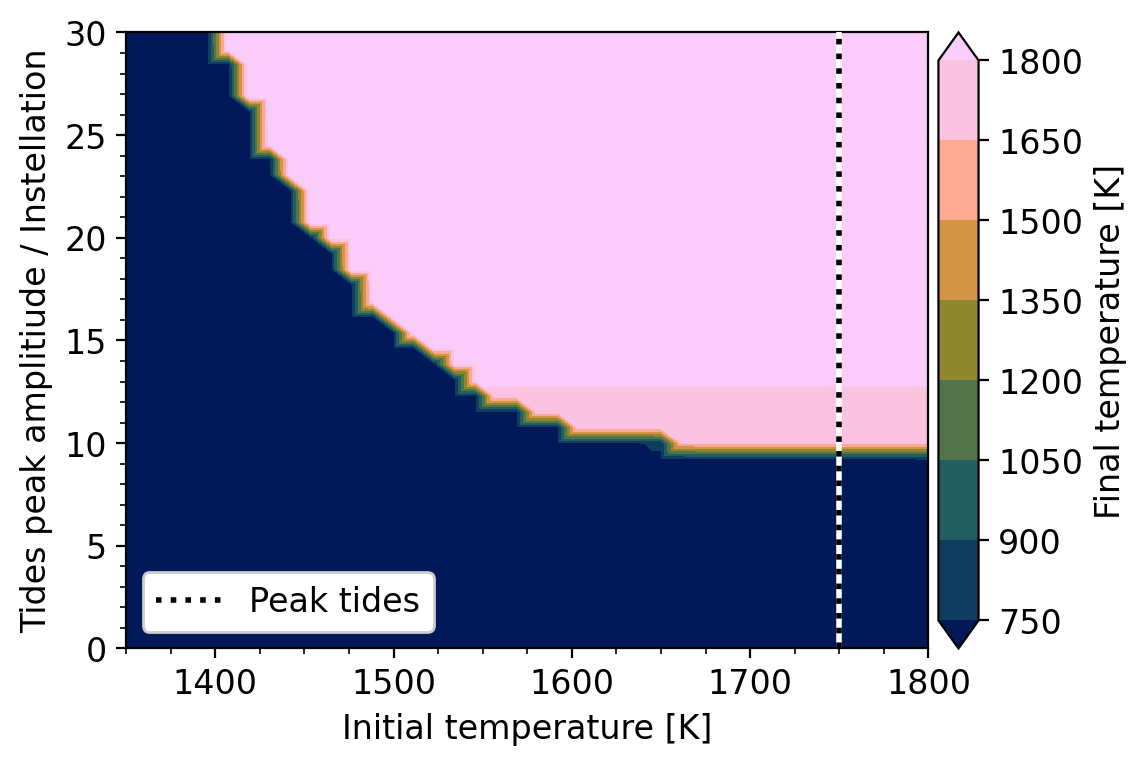

In [14]:
# multiple dimensions
fig, ax = plt.subplots(1,1, figsize=(5.5,4))

cmap = deepcopy(cm.batlow)
norm = mpl.colors.Normalize(vmin=np.percentile(z_arr,45), vmax=np.percentile(z_arr,55))
mp = ax.tricontourf(x_arr, y_arr, z_arr, cmap=cmap, norm=norm, levels=8, zorder=1, extend='both')

# mixed phase region
ax.axvline(pl.T_cen, color='w',ls='solid', lw=2, zorder=4)
ax.axvline(pl.T_cen, color='k', label="Peak tides", ls='dotted', lw=2, zorder=5)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mp, cax=cax, orientation='vertical')
cbar.set_label("Final temperature [K]")

ax.set_xlabel("Initial temperature [K]")
ax.set_xlim(left=x_arr[0], right=x_arr[-1])
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

ax.set_ylabel("Tides peak amplitiude / Instellation")
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(framealpha=1.0, loc='lower left')

plt.show()
fig.savefig("output/sa_contour.pdf", bbox_inches="tight")

/tmp/ipykernel_697398/714330114.py:43: RuntimeWarning: overflow encountered in scalar power
  F_int = self.F_c * np.exp(-1.0 * ((Tt-self.T_cen)/self.T_wid)**2)
/tmp/ipykernel_697398/714330114.py:47: RuntimeWarning: overflow encountered in scalar power
  out -= sbc * self.ems * Tt**4


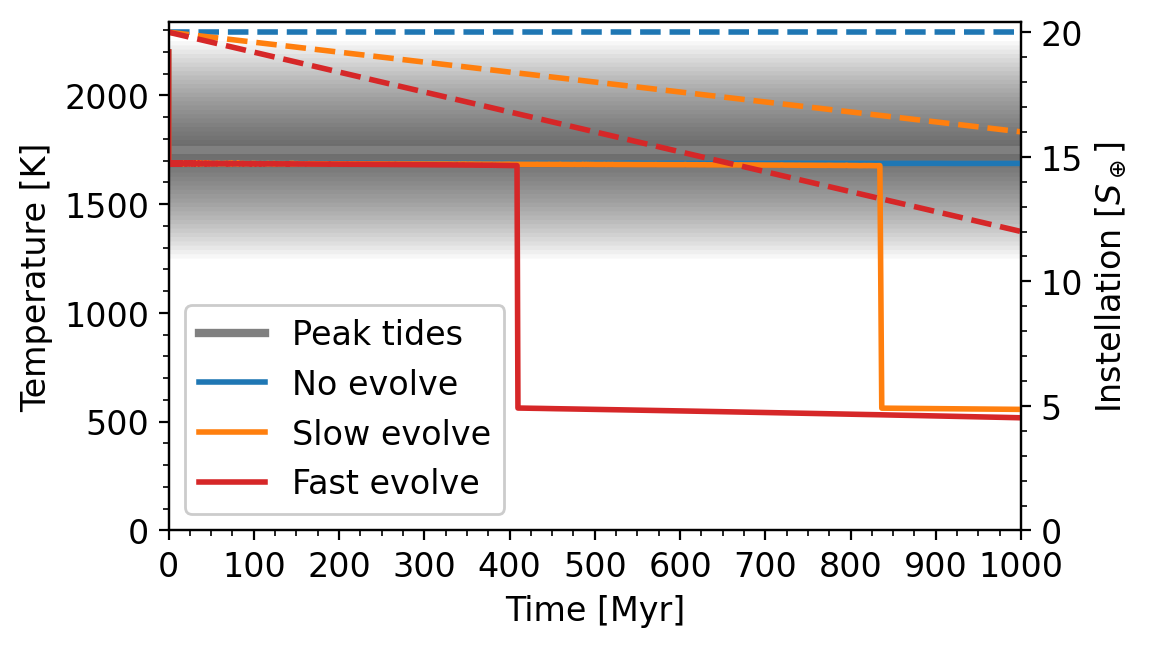

In [15]:
# instellation evolution cases
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))
axr = ax.twinx()

# mixed phase region
res = 25
for q in np.linspace(0.1, 2.0, res):
    ax.fill_between(sol_x, pl.T_cen+pl.T_wid*q, pl.T_cen-pl.T_wid*q, color='k', alpha=0.8/res, edgecolor=None, zorder=0)
ax.axhline(pl.T_cen, color='grey', label="Peak tides", ls='solid', lw=3, zorder=1)

t_max = 1e9
lw=2

# No stellar evolution
pl.T_0 = 2200
pl.S_0 = 20 * S_earth
pl.F_c = 248 * S_earth
pl.dSx = 0.0# -S_earth / (1e5 * year)
c = 'tab:blue'
sol_tim, sol_tmp, sol_ins = pl.solve(t_max=t_max, atol=1e-3, rtol=1e-4)
ax.plot(sol_tim /1e6, sol_tmp, label=r"No evolve", zorder=4, lw=lw, c=c)
axr.plot(sol_tim/1e6, sol_ins / S_earth, c=c, lw=lw, ls='dashed')

# With stellar evolution
pl = planet()
pl.T_0 = 2200
pl.S_0 = 20 * S_earth
pl.F_c = 248 * S_earth
pl.dSx = -0.4*S_earth / (1e8 * year)
c = 'tab:orange'
sol_tim, sol_tmp, sol_ins = pl.solve(t_max=t_max, atol=1e-3, rtol=1e-4, nsamps=1e4)
ax.plot(sol_tim /1e6, sol_tmp, label=r"Slow evolve", zorder=4, lw=lw, c=c)
axr.plot(sol_tim/1e6, sol_ins / S_earth, c=c, lw=lw, ls='dashed')

# With stellar evolution
pl = planet()
pl.T_0 = 2200
pl.S_0 = 20 * S_earth
pl.F_c = 248 * S_earth
pl.dSx = -0.8*S_earth / (1e8 * year)
c = 'tab:red'
sol_tim, sol_tmp, sol_ins = pl.solve(t_max=t_max, atol=1e-3, rtol=1e-4, nsamps=1e4)
ax.plot(sol_tim /1e6, sol_tmp, label=r"Fast evolve", zorder=4, lw=lw, c=c)
axr.plot(sol_tim/1e6, sol_ins / S_earth, c=c, lw=lw, ls='dashed')

ax.set_xlabel("Time [Myr]")
ax.set_xlim(left=0, right=t_max/1e6)
ax.set_ylabel("Temperature [K]")
ax.set_ylim(bottom=0)
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))

axr.set_ylim(bottom=0)
axr.set_ylabel(r"Instellation [$S_\oplus$]")
axr.yaxis.set_major_locator(MultipleLocator(5))
axr.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(framealpha=1.0, loc='lower left', bbox_to_anchor=(0,0))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

plt.show()
fig.savefig("output/sa_dimming.pdf", bbox_inches="tight")

In [154]:
# critical instellation
t_max = 2e3
lw=2

S0_arr = np.linspace(1,   250, 60)
Fc_arr = np.linspace(175, 300, 60)

# With stellar evolution
x_plt = []
y_plt = []
z_plt = []
for S0 in S0_arr:
    for i,F_c in enumerate(Fc_arr):
        pl = planet()
        pl.T_0 = 3000
        pl.S_0 = S0 * S_earth
        pl.F_c = F_c * S_earth
        pl.r2  = pl.r2*4
        pl.c_p = 10.0
        sol_tim, sol_tmp, sol_ins = pl.solve(t_max=t_max, atol=1e-3, rtol=1e-4, nsamps=1e3)

        y_plt.append(F_c)
        x_plt.append(S0)
        z_plt.append(pl._phi(sol_tmp[-1])*100)

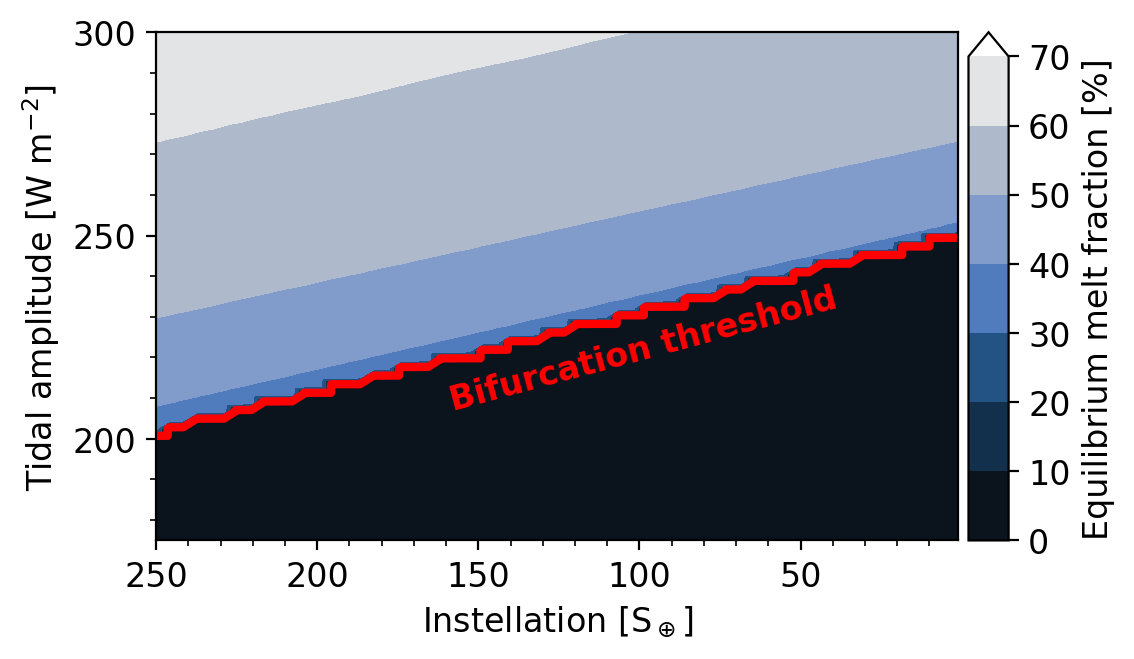

In [198]:

figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))

cmap = deepcopy(cm.oslo)
levels = np.arange(0, 80, 10)
sm = ax.tricontourf(x_plt,y_plt,z_plt,cmap=cmap, levels=levels, extend='max')

ax.tricontour(x_plt,y_plt,z_plt, levels=[0, 5], colors=['red'], linewidths=3)
ax.text(160, 207, "Bifurcation threshold", color='red', rotation=15, weight='bold', fontsize=12)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label("Equilibrium melt fraction [%]")

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_ylabel(r"Tidal amplitude [W m$^{-2}$]")

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlabel(r"Instellation [S$_\oplus$]")
ax.invert_xaxis()

plt.show()
fig.savefig("output/sa_bithresh.pdf", bbox_inches='tight')